In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

import random
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

random_state = 42

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.expand_frame_repr', False)  # Don't wrap lines
pd.set_option('display.precision', 4)  # Set decimal precision

In [2]:
df = pd.read_csv('data/application_write_off_risk.csv')

In [3]:
def encode_loan_status(status):
    return 1 if (status == 'WRITE-OFF' or status == "REPOED") else 0

def encode_loan_status_str(status):
    return 'Write-Off' if (status == 'WRITE-OFF' or status == "REPOED") else 'Active'

### Data Preparation

In [4]:
df_filtered = df.query('term < 180')
df_filtered.dropna(inplace=True)
df_filtered['loanStatusStr'] = df_filtered['loanStatus'].apply(encode_loan_status_str)
df_filtered['loanStatus'] = df_filtered['loanStatus'].apply(encode_loan_status)
x = df_filtered.drop(columns=[
    'acctno', 
    'loanStatus', 
    'loanStatusStr',
    'job_title', 
    'job_company', 
    'job_employment_status', 
    'make', 
    'model', 
    'year',
    'job_verified'
])
y = df_filtered['loanStatus']

### Loan Status Distribution
Check distribution of loan status, to see how balanced the dataset is.

In [5]:
y.value_counts()

loanStatus
0    464
1    224
Name: count, dtype: int64

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Train Models
We'll train, KNN, Logistic Regression, and SVC models.

In [7]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['industry']),
    remainder=StandardScaler()
)

In [8]:
dmap = {}

#### KNN

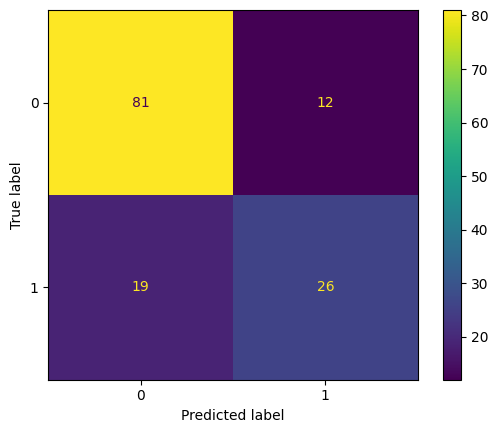

In [9]:
pipe_knn = Pipeline([
    ('transformer', transformer),
    ('model', KNeighborsClassifier())
])

grid_knn = GridSearchCV(
    pipe_knn, 
    param_grid={
        'model__n_neighbors': range(3, 70, 2)
    }, 
    scoring='precision',
)
grid_knn.fit(x, y)

dmap['knn'] = {
    'test_score': grid_knn.score(x_test, y_test),
    'model': 'KNN',
    'recall_score': recall_score(y_test, grid_knn.predict(x_test), average='weighted'),
    'precision_score': precision_score(y_test, grid_knn.predict(x_test), average='weighted'),
    'accuracy_score': accuracy_score(y_test, grid_knn.predict(x_test)),
    'f1_score': f1_score(y_test, grid_knn.predict(x_test), average='weighted'),
}

ConfusionMatrixDisplay.from_estimator(grid_knn.best_estimator_, x_test, y_test)

#### Logistic Regression

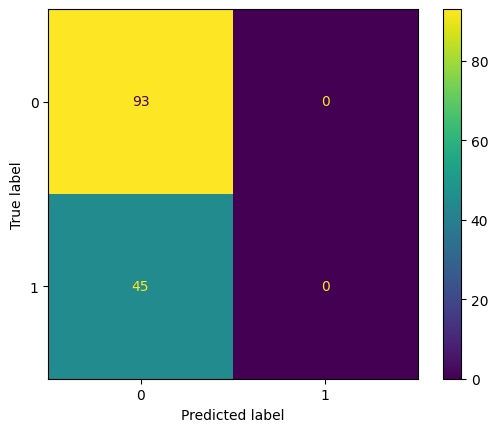

In [10]:
pipe_lgr = Pipeline([
    ('transformer', transformer),
    ('model', LogisticRegression(class_weight='balanced'))
])

grid_lgr = GridSearchCV(
    pipe_lgr, 
    param_grid={
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga'],
    }, 
    scoring='precision',
)
grid_lgr.fit(x_train, y_train)

dmap['logistic_regression'] = {
    'test_score': grid_lgr.score(x_test, y_test),
    'model': 'Logistic Regression',
    'recall_score': recall_score(y_test, grid_lgr.predict(x_test), average='weighted'),
    'precision_score': precision_score(y_test, grid_lgr.predict(x_test), average='weighted'),
    'accuracy_score': accuracy_score(y_test, grid_lgr.predict(x_test)),
    'f1_score': f1_score(y_test, grid_lgr.predict(x_test), average='weighted'),
}

ConfusionMatrixDisplay.from_estimator(grid_lgr.best_estimator_, x_test, y_test)


#### SVC

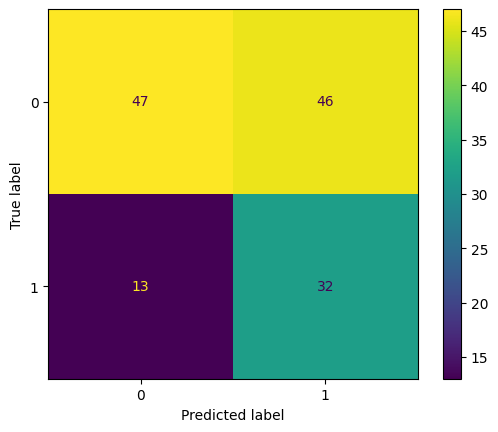

In [11]:
pipe_svc = Pipeline([
    ('transformer', transformer),
    ('model', SVC(class_weight='balanced'))
])

grid_svc = GridSearchCV(
    pipe_svc, 
    param_grid={
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    }, 
    scoring='precision',
)
grid_svc.fit(x, y)

dmap['svc'] = {
    'test_score': grid_svc.score(x_test, y_test),
    'model': 'SVC',
    'recall_score': recall_score(y_test, grid_svc.predict(x_test), average='weighted'),
    'precision_score': precision_score(y_test, grid_svc.predict(x_test), average='weighted'),
    'accuracy_score': accuracy_score(y_test, grid_svc.predict(x_test)),
    'f1_score': f1_score(y_test, grid_svc.predict(x_test), average='weighted'),
}

ConfusionMatrixDisplay.from_estimator(grid_svc.best_estimator_, x_test, y_test)


### Results

In [12]:
df_results = pd.DataFrame(dmap.values())
df_results.sort_values(by='test_score', ascending=False)


,test_score,model,recall_score,precision_score,accuracy_score,f1_score
0,0.6842,KNN,0.7754,0.7690,0.7754,0.7700
2,0.4103,SVC,0.5725,0.6617,0.5725,0.5837
1,0.0000,Logistic Regression,0.6739,0.4542,0.6739,0.5426


When analyzing performance, we can see that the KNN model performs the best, with a recall score of 77%.

### Feature Importance


In [13]:
result = permutation_importance(grid_knn.best_estimator_, x_test, y_test, n_repeats=10, random_state=42)
df_perm = pd.DataFrame(result.importances.T, columns=x_test.columns)
df_perm.mean().sort_values(ascending=False)

industry           0.1536
term               0.0928
monthly_payment    0.0732
monthly_income     0.0565
res_time_months    0.0558
fundedAmount       0.0428
job_time_months   -0.0036
dtype: float64

Analyzing feature importance unveils that the most important features are industry, and term. Let's analyze the industry risk.

### Industry Risk Analysis

In [14]:
df_fil2 = df_filtered[['industry', 'loanStatusStr', 'loanStatus']].groupby(['industry', 'loanStatusStr']).count()
fig = px.bar(
    df_fil2.reset_index(), 
    x='industry', 
    y='loanStatus', 
    color='loanStatusStr', 
    title='Industry Risk', 
    labels={'loanStatus': 'Write-Off Risk', 'industry': 'Industry', 'loanStatusStr': 'Risk'},
)
fig.show()


In [15]:
df_industry_risk = df_filtered.groupby('industry').agg({
    'loanStatusStr': lambda x: (x == 'Write-Off').mean() * 100
}).reset_index()

df_industry_risk.columns = ['industry', 'write_off_percentage'] 
df_industry_risk = df_industry_risk.sort_values('write_off_percentage', ascending=False)

# Plot the results
fig = px.bar(
    df_industry_risk,
    x='industry',
    y='write_off_percentage',
    title='Percentage of Write-Offs by Industry',
    labels={
        'industry': 'Industry',
        'write_off_percentage': 'Write-Off Percentage (%)'
    }
)
fig.show()


The graph above shows the percentage of write-offs per industry. Transport and real estate have the highest percentage of write-offs.